In [365]:
import pandas as pd

df_train = pd.read_csv('../data/vn30/VRE_train.csv')

feature_columns = ['open', 'high', 'low', 'close', 'volume']
num_features = len(feature_columns)
timeseries_df_train = df_train[feature_columns].astype('float32') 
data_values_train = timeseries_df_train.values 

data_values_train

array([[2.763000e+01, 2.856000e+01, 2.758000e+01, 2.797000e+01,
        2.061280e+06],
       [2.812000e+01, 2.812000e+01, 2.671000e+01, 2.691000e+01,
        1.247100e+06],
       [2.671000e+01, 2.700000e+01, 2.593000e+01, 2.671000e+01,
        9.827900e+05],
       ...,
       [2.330000e+01, 2.345000e+01, 2.320000e+01, 2.325000e+01,
        3.221203e+06],
       [2.325000e+01, 2.370000e+01, 2.325000e+01, 2.350000e+01,
        6.106563e+06],
       [2.365000e+01, 2.365000e+01, 2.330000e+01, 2.330000e+01,
        4.355689e+06]], shape=(1250, 5), dtype=float32)

In [366]:
from sklearn.preprocessing import MinMaxScaler

train_size_ratio = 0.7

train_size = int(len(data_values_train) * train_size_ratio)
valid_size = len(data_values_train) - train_size

scaler = MinMaxScaler(feature_range=(0, 1))

data_values_train_scaled_full = scaler.fit_transform(data_values_train)
train_data_scaled, valid_data_scaled = data_values_train_scaled_full[:train_size], data_values_train_scaled_full[train_size:]

train_data_scaled, valid_data_scaled

(array([[0.49402988, 0.5076923 , 0.52224946, 0.5109453 , 0.06945514],
        [0.51840806, 0.48653847, 0.47970665, 0.45820892, 0.03627885],
        [0.44825864, 0.43269235, 0.44156492, 0.44825864, 0.02550872],
        ...,
        [0.539801  , 0.5120192 , 0.53789735, 0.5447761 , 0.05908556],
        [0.55970156, 0.52644235, 0.5599023 , 0.53731346, 0.0249468 ],
        [0.53731346, 0.5192308 , 0.54034245, 0.5099503 , 0.02944947]],
       shape=(875, 5), dtype=float32),
 array([[0.49253738, 0.48076922, 0.4449879 , 0.41293538, 0.11629589],
        [0.42288566, 0.43269235, 0.45476782, 0.46268654, 0.08336328],
        [0.46268654, 0.4447115 , 0.47432768, 0.46268654, 0.02773805],
        ...,
        [0.2786069 , 0.26201922, 0.3080685 , 0.27611935, 0.1167198 ],
        [0.27611935, 0.2740385 , 0.3105135 , 0.28855717, 0.23429275],
        [0.2960199 , 0.27163464, 0.31295848, 0.2786069 , 0.16294795]],
       shape=(375, 5), dtype=float32))

In [367]:
import torch
import numpy as np

def create_dataset(dataset, lookback, num_features):
    """
    Transform a time series with multiple features into a prediction dataset.
    Args:
        dataset: A numpy array of time series (num_timesteps, num_features)
        lookback: Size of window for prediction
        num_features: Number of features in the dataset
    Returns:
        X: (num_samples, lookback, num_features)
        y: (num_samples, num_features) - features for the single next day
    """
    X, y = [], []

    for i in range(len(dataset) - lookback):
        feature_window = dataset[i:i+lookback]
        target_day = dataset[i+lookback] # Dự đoán 5 features của ngày tiếp theo
        X.append(feature_window)
        y.append(target_day)
    
    if not X: # Nếu X rỗng sau vòng lặp (có thể xảy ra nếu len(dataset) - lookback = 0)
         return torch.empty(0, lookback, num_features, dtype=torch.float32), \
               torch.empty(0, num_features, dtype=torch.float32)

    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

In [368]:
lookback = 5
X_train, y_train = create_dataset(train_data_scaled, lookback=lookback, num_features=num_features)
X_valid, y_valid = create_dataset(valid_data_scaled, lookback=lookback, num_features=num_features)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_test shape: {y_valid.shape}")

X_train shape: torch.Size([870, 5, 5]), y_train shape: torch.Size([870, 5])
X_valid shape: torch.Size([370, 5, 5]), y_test shape: torch.Size([370, 5])


In [369]:
import torch.nn as nn

class StockPredictorModel(nn.Module):
    def __init__(self, input_features, hidden_size, num_output_features):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_features, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_output_features)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step_out)
        return y_pred

In [370]:
import torch.optim as optim
import torch.utils.data as data

hidden_layer_size = 128
model = StockPredictorModel(input_features=num_features, hidden_size=hidden_layer_size, num_output_features=num_features)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=16)

In [371]:
from sklearn.metrics import r2_score
n_epochs = 200
print_every = 50 

best_val_loss = float('inf')

print("\nBắt đầu quá trình huấn luyện...")
for epoch in range(1, n_epochs+1):
    # --- training ---
    model.train()
    train_loss_sum = 0.0
    for Xb, yb in loader:
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
    avg_train_loss = train_loss_sum / len(loader)

    # --- tính validation loss ---
    model.eval()
    with torch.no_grad():
        val_pred = model(X_valid)
        val_loss = loss_fn(val_pred, y_valid).item()

    # --- lưu model nếu validation loss giảm ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_LSTM_model.pth')

    # --- in thông tin ---
    if epoch % print_every == 0 or epoch == n_epochs:
        print(f"Epoch {epoch:3d}/{n_epochs}: "
              f"Train Loss = {avg_train_loss:.6f}, "
              f"Valid Loss = {val_loss:.6f}, "
              f"Best Val Loss = {best_val_loss:.6f}")

print("\nHoàn thành huấn luyện.")


Bắt đầu quá trình huấn luyện...
Epoch  50/200: Train Loss = 0.002029, Valid Loss = 0.001560, Best Val Loss = 0.001491
Epoch 100/200: Train Loss = 0.001884, Valid Loss = 0.001400, Best Val Loss = 0.001379
Epoch 150/200: Train Loss = 0.001818, Valid Loss = 0.001446, Best Val Loss = 0.001379
Epoch 200/200: Train Loss = 0.001744, Valid Loss = 0.001481, Best Val Loss = 0.001379

Hoàn thành huấn luyện.


In [372]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

model.load_state_dict(torch.load('best_LSTM_model.pth', map_location='cpu'))
model.eval()

with torch.no_grad():
    y_pred_val_scaled = model(X_valid)
    y_pred_val = scaler.inverse_transform(y_pred_val_scaled.cpu().numpy())
    y_true_val = scaler.inverse_transform(y_valid.cpu().numpy())

mse_val = mean_squared_error(y_true_val.flatten(), y_pred_val.flatten())
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_true_val.flatten(), y_pred_val.flatten())
mape_val = mean_absolute_percentage_error(y_true_val.flatten(), y_pred_val.flatten()) * 100

print("\n--- KẾT QUẢ TRÊN TẬP VALID  ---")
print(f"RMSE: {rmse_val}")
print(f"R²: {r2_val}")
print(f"MAPE: {mape_val}%")


--- KẾT QUẢ TRÊN TẬP VALID  ---
RMSE: 749563.0600930118
R²: 0.8031473159790039
MAPE: 8.787960559129715%


In [373]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Chuẩn bị dữ liệu test 
df_test = pd.read_csv('../data/vn30/VRE_test.csv')
timeseries_df_test = df_test[feature_columns].astype('float32')
data_test_raw = timeseries_df_test.values

data_test_scaled = scaler.transform(data_test_raw)

# tạo tập X_test, y_test giống ở train
X_test, y_test = create_dataset(data_test_scaled, lookback, num_features)

model.load_state_dict(torch.load('best_LSTM_model.pth', map_location='cpu'))
model.eval()

with torch.no_grad():
    y_pred_scaled = model(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.numpy())
    y_true = scaler.inverse_transform(y_test.numpy())

mse_test = mean_squared_error(y_true.flatten(), y_pred.flatten())
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_true.flatten(), y_pred.flatten())
mape_test = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten()) * 100

print("--- KẾT QUẢ TRÊN TẬP TEST ---")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")
print(f"MAPE: {mape_test}%")


--- KẾT QUẢ TRÊN TẬP TEST ---
RMSE: 2444886.6899813577
R²: 0.7091266512870789
MAPE: 8.48587304353714%


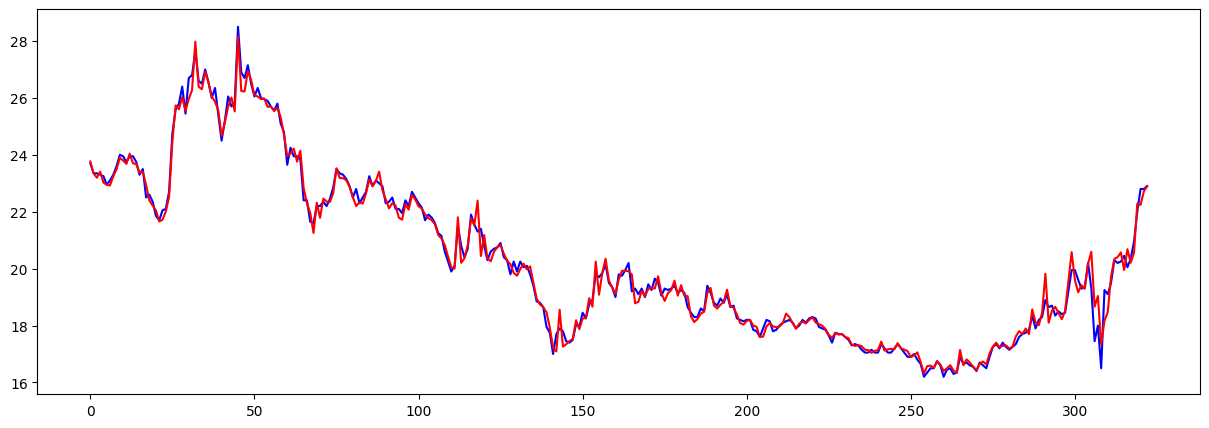

In [374]:

import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 0], label='Giá thực tế', color='blue')
plt.plot(y_pred[:, 0], label='Giá dự đoán', color='red')

plt.show()